# Experiments on B3 samples

#### Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader



import warnings
warnings.filterwarnings('ignore')


: 

In [115]:
RANDOM_STATE = 42
DEVICE = "mps:0" if torch.mps.is_available() else "cpu"

LATENT_DIMS = [10, 50, 100]
BATCH_SIZE = 64
EPOCHS = 100
LR = 1e-3


### Data Loading

### Quick EDA on data obtained with MicrobAI conversion  

**MicrobAI** ingests raw LC‑MS/MS TSVs and converts them into a structured, ML‑ready table where each row is a sample and each column is a chemically meaningful feature derived from retention time and m/z binning, with labels and batch metadata included for downstream analysis. 

The main file to use is **inputs_none.csv** which contains log‑stabilized intensities per feature.

These are the results obtained from the B3 file after conversion using the microbAI python scripts.

In [116]:
df = pd.read_csv('../data/test_B3_mz0-10000rt0-320/inputs_none.csv', index_col='ID')
meta = df[['label','batch']]
X = df.drop(columns=['label','batch'])
y = df['label']

print("Samples:", len(df), "Features:", X.shape[1])
print("Batches:", meta['batch'].value_counts().to_dict())
print("Labels:", meta['label'].value_counts().to_dict())



Samples: 216 Features: 242
Batches: {'b3': 216}
Labels: {'sma': 24, 'pmi': 24, 'efa': 24, 'cal': 24, 'slu': 24, 'api': 24, 'cfr': 24, 'blanc': 24, 'pae': 24}


In [117]:
df.head(15)

,label,batch,359.0_0_240,359.0_0_250,359.0_0_270,359.0_0_280,359.0_0_300,359.0_0_310,359.0_0_330,359.0_0_340,...,378.0_320_400,378.0_320_420,378.0_320_450,378.0_320_480,378.0_320_510,378.0_320_600,378.0_320_610,378.0_320_640,378.0_320_690,378.0_320_720
ID,,,,,,,,,,,,,,,,,,,,,
sma_b3-02-29-2024_240216_u103_l,sma,b3,394.946045,646.908813,3094.615234,4426.816895,2586.239990,3210.817871,3058.274658,2307.285645,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
pmi_b3-02-29-2024_230802_u111_l,pmi,b3,356.655029,397.186707,3014.669922,4356.538086,2935.968018,2395.559326,3403.313965,1915.991455,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
efa_b3-02-29-2024_231108_u119_l,efa,b3,697.982483,124.752884,3521.652588,3313.381348,2856.565430,3552.208252,3571.083740,1748.631104,...,0.0,0.0,0.0,0.0,11.035786,0.000000,0.0,0.0,0.0,0.0
cal_b3-02-29-2024_240221_u068_h,cal,b3,385.513550,247.268707,2555.779297,4045.059326,2706.452637,3590.715820,3400.973633,2237.392578,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
sma_b3-02-29-2024_240216_u123_h,sma,b3,256.122406,222.392578,4068.693604,3963.408203,2600.627441,4170.655762,4010.141357,1472.380981,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
efa_b3-02-29-2024_231108_u024_h,efa,b3,389.738251,495.006836,4483.312012,5726.499023,2724.218994,3098.467041,2837.152344,1668.162598,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
slu_b3-02-29-2024_240216_u070_h,slu,b3,325.548584,422.836456,3166.335693,3856.853760,2348.488037,2595.341797,2436.205811,1597.024170,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
cal_b3-02-29-2024_240221_u077_l,cal,b3,274.782074,415.657684,3417.378418,5270.041504,2734.475098,2868.529541,2837.198486,1977.722534,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
slu_b3-02-29-2024_240216_u128_h,slu,b3,269.014160,316.876465,3403.516602,2885.620605,1907.063843,2615.807129,2375.244385,1049.865845,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0


### Prepocessing
Train - Test Split + Scaling  + Label Encoding

In [118]:
le = LabelEncoder()
y_enc = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X.values,
    y_enc,
    test_size=0.2,
    stratify=y_enc,
    random_state=RANDOM_STATE
)


In [119]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


### MLP Classifer

In [120]:
class MLP(nn.Module):
    def __init__(self, input_dim, n_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, n_classes)
        )

    def forward(self, x):
        return self.net(x)


In [121]:
def train_classifier(X_train, y_train, X_test, y_test, input_dim, n_classes):
    model = MLP(input_dim, n_classes).to(DEVICE)

    train_loader = DataLoader(
        TensorDataset(
            torch.tensor(X_train, dtype=torch.float32),
            torch.tensor(y_train, dtype=torch.long)
        ),
        batch_size=BATCH_SIZE,
        shuffle=True
    )

    val_loader = DataLoader(
        TensorDataset(
            torch.tensor(X_test, dtype=torch.float32),
            torch.tensor(y_test, dtype=torch.long)
        ),
        batch_size=BATCH_SIZE
    )

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    best_f1 = 0.0
    best_state = None

    for epoch in range(EPOCHS):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()

        # validation
        model.eval()
        preds, trues = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(DEVICE)
                out = model(xb)
                preds.append(out.argmax(1).cpu().numpy())
                trues.append(yb.numpy())

        preds = np.concatenate(preds)
        trues = np.concatenate(trues)

        accuracy = accuracy_score(trues, preds)
        f1 = f1_score(trues, preds, average='macro')
        if f1 > best_f1:
            best_f1 = f1
            best_state = model.state_dict()

    model.load_state_dict(best_state)
    return model,accuracy, best_f1


### PCA Pipeline

In [122]:
results = []

n_classes = len(np.unique(y_enc))

for dim in LATENT_DIMS:
    pca = PCA(n_components=dim, random_state=RANDOM_STATE)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    _, accuracy, f1 = train_classifier(
        X_train_pca, y_train,
        X_test_pca, y_test,
        input_dim=dim,
        n_classes=n_classes
    )

    results.append({
        'method': 'PCA',
        'latent_dim': dim,
        'accuracy': accuracy,
        'f1_macro': f1
    })


### AutoEncoder Pipeline

In [123]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z), z


In [124]:
def train_autoencoder(X_train, X_test, latent_dim):
    model = Autoencoder(X_train.shape[1], latent_dim).to(DEVICE)

    loader = DataLoader(
        torch.tensor(X_train, dtype=torch.float32),
        batch_size=BATCH_SIZE,
        shuffle=True
    )

    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    criterion = nn.MSELoss()

    best_val = np.inf
    best_state = None

    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(DEVICE)

    for _ in range(EPOCHS):
        model.train()
        for xb in loader:
            xb = xb.to(DEVICE)
            optimizer.zero_grad()
            recon, _ = model(xb)
            loss = criterion(recon, xb)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            recon, _ = model(X_test_tensor)
            val_loss = criterion(recon, X_test_tensor).item()

        if val_loss < best_val:
            best_val = val_loss
            best_state = model.state_dict()

    model.load_state_dict(best_state)
    return model


In [125]:
for dim in LATENT_DIMS:
    ae = train_autoencoder(X_train, X_test, dim)

    with torch.no_grad():
        Z_train = ae.encoder(
            torch.tensor(X_train, dtype=torch.float32).to(DEVICE)
        ).cpu().numpy()

        Z_val = ae.encoder(
            torch.tensor(X_test, dtype=torch.float32).to(DEVICE)
        ).cpu().numpy()

    _, accuracy, f1 = train_classifier(
        Z_train, y_train,
        Z_val, y_test,
        input_dim=dim,
        n_classes=n_classes
    )

    results.append({
        'method': 'Autoencoder',
        'latent_dim': dim,
        'accuracy': accuracy,
        'f1_macro': f1
    })


### Results

In [126]:
results_df = pd.DataFrame(results)
print(results_df)


        method  latent_dim  accuracy  f1_macro
0          PCA          10  0.363636  0.369301
1          PCA          50  0.318182  0.393827
2          PCA         100  0.340909  0.367845
3  Autoencoder          10  0.272727  0.284210
4  Autoencoder          50  0.386364  0.375563
5  Autoencoder         100  0.318182  0.393723


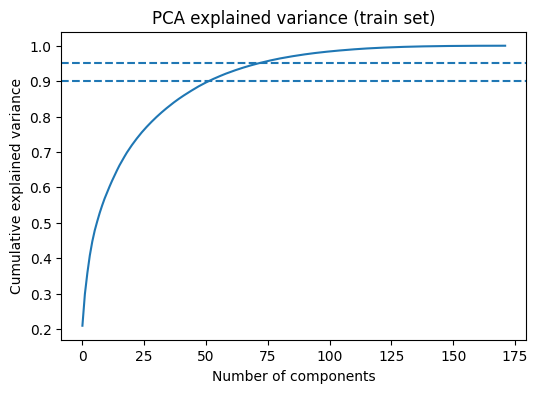

In [127]:
pca_full = PCA(random_state=RANDOM_STATE)
pca_full.fit(X_train)

cum_var = np.cumsum(pca_full.explained_variance_ratio_)

plt.figure(figsize=(6,4))
plt.plot(cum_var)
plt.axhline(0.9, linestyle='--')
plt.axhline(0.95, linestyle='--')
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA explained variance (train set)")
plt.show()


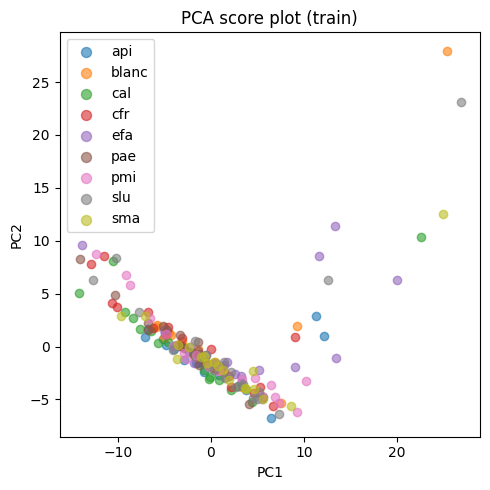

In [128]:
pca_2 = PCA(n_components=2, random_state=RANDOM_STATE)
X_train_pca2 = pca_2.fit_transform(X_train)

plt.figure(figsize=(5,5))
for lab in np.unique(y_train):
    mask = y_train == lab
    plt.scatter(
        X_train_pca2[mask, 0],
        X_train_pca2[mask, 1],
        label=le.inverse_transform([lab])[0],
        alpha=0.6
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA score plot (train)")
plt.legend(markerscale=1.2)
plt.tight_layout()
plt.show()


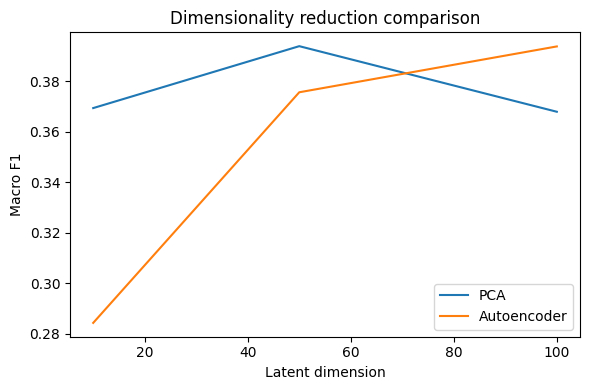

In [129]:
plt.figure(figsize=(6,4))

for method in results_df['method'].unique():
    sub = results_df[results_df['method'] == method]
    plt.plot(
        sub['latent_dim'],
        sub['f1_macro'],
        label=method
    )

plt.xlabel("Latent dimension")
plt.ylabel("Macro F1")
plt.title("Dimensionality reduction comparison")
plt.legend()
plt.tight_layout()
plt.show()
